<a href="https://colab.research.google.com/github/IngyBadawi/Image-Segmentation/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #2 Image Segmentation

**Done by:** 

Jailan Mahmoud Hussein - 5733

Habiba Adel - 5771

Ingy Ahmed Badawi - 5777

Rowaida Hamdy Mohamed - 5828

Jolie Sameh Halim - 5865

Imports

In [49]:
import numpy as np
import math

# For visualization
from matplotlib import image 
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io
from PIL import Image
import random

# # For file handling
from google.colab import files

# For unzipping
from zipfile import ZipFile
import glob

# For image segmantaion
from sklearn.cluster import KMeans
import cv2 as cv
import os

## 1. Download the Dataset and Understand the Format

* If working on Google Collab

In [38]:
!wget -q {"http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"}
!tar -xzf /content/BSR_bsds500.tgz

# Creating the output directory
!mkdir '/content/output'
!mkdir '/content/output/Ground-Truth'
!mkdir '/content/output/Test-Segmented-Images/'
!mkdir '/content/output/Test-Segmented-Images/Segmented_vs_GT'
!mkdir '/content/output/Test-Segmented-Images/Modified_Segmented_vs_GT'
!mkdir '/content/output/Test-Segmented-Images/Modifed_vs_Normally_Segmented_Images'

mkdir: cannot create directory ‘/content/output’: File exists
mkdir: cannot create directory ‘/content/output/Ground-Truth’: File exists
mkdir: cannot create directory ‘/content/output/Test-Segmented-Images/’: File exists
mkdir: cannot create directory ‘/content/output/Test-Segmented-Images/Segmented_vs_GT’: File exists
mkdir: cannot create directory ‘/content/output/Test-Segmented-Images/Modified_Segmented_vs_GT’: File exists


* If working on local host

In [ ]:
## Unzip and extract data
data = ZipFile('BSR.zip', 'r')

#Get complete listing of the zip archive contents
dataList=data.namelist()

# extracting all the files
data.extractall()

## Create 'content' directory to save 'output' directory inside
# Directory
directory = "content"
    
# Parent Directory path
parent_dir = "."

# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Create 'output' directory to save all outputs inside
directory = "output"
    
# Parent Directory path
parent_dir = "./content"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Create 'Ground Truth' directory
directory = "Ground-Truth"
    
# Parent Directory path
parent_dir = "./content/output"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

* Unzip and extract images

In [3]:
#Get the images for training
train = sorted(glob.glob("BSR/BSDS500/data/images/train/**/*.jpg", recursive=True))

#Get the images for testing
test = sorted(glob.glob("BSR/BSDS500/data/images/test/**/*.jpg", recursive=True))
test = test[0:50]

#Get the ground-truth for training
gt_train = sorted(glob.glob("BSR/BSDS500/data/groundTruth/train/**/*.mat", recursive=True))

#Get the ground-truth for testing
gt_test = sorted(glob.glob("BSR/BSDS500/data/groundTruth/test/**/*.mat", recursive=True))
gt_test = gt_test[0:50]

In [4]:
# A utility function that returns the datasets corresponding to the given the dataset name
def get_datasets(dataset_name):
  if dataset_name == "TRAIN":
    return train, gt_train
  if dataset_name == "TEST":
    return test, gt_test

## 2. Visualize the image and the ground truth segmentation

In [24]:
# A function that returns an array of ground truth images for a given index in a given dataset
def get_ground_truth_images_array(index, dataset):
  
  # Loading the ground truth images from the corresponding .mat file
  ground_truth_img = scipy.io.loadmat(dataset[index])

  #print(ground_truth_img)
  ground_truth_img = np.squeeze(ground_truth_img['groundTruth'])
  gt_images = []

  #Appending the ground truth segmentations in the list 
  for i in range(len(ground_truth_img)):
    curr_ground_truth = ground_truth_img[i][0][0][0]
    gt_images.append(curr_ground_truth)
  
  return gt_images

In [9]:
# A function that returns a figure that contains all the 5 ground truth images 
# corresponding to a specific index in a given dataset
def get_ground_truth_images(index, dataset_name):

  # Specifying path and file name to save it later
  my_path = '/content/output/Ground-Truth' #(if on Google Collab)
  # my_path = './content/output/Ground-Truth'
  my_file = 'GT_only_' + str(dataset_name).lower() + '_' + str(index)

  # Fetching the ground truth dataset
  _, gt_dataset = get_datasets(dataset_name)

  # Save ground truth images in 'imgs' list in order to pack them in one figure
  imgs = get_ground_truth_images_array(index, gt_dataset)

  # Specifying the size and shape of the figure and its 5 axes
  fig = plt.figure(figsize=(20, 10))
  gs = gridspec.GridSpec(2, 6)
  gs.update(wspace=0.5)
  ax1 = fig.add_subplot(gs[0,:3])
  ax2 = fig.add_subplot(gs[0,3:])
  ax3 = fig.add_subplot(gs[1, 0:2])
  ax4 = fig.add_subplot(gs[1, 2:4])
  ax5 = fig.add_subplot(gs[1, 4:6])

  # Packing the axes in 'axes' list to be ready for plotting
  axes = [ax1, ax2, ax3, ax4, ax5]

  # Plotting the images in the axes
  for ax, im in zip(axes, imgs):
    ax.imshow(im)

  # Saving and returning the collective figure
  plt.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')
  return fig

In [10]:
def visualize_6_images(first_im, im_array, my_file, my_path, show):

  fig, axarr = plt.subplots(2,3,figsize=(20, 10))
  
  # Loop through the list and plot each image
  for i in range(len(im_array) + 1):
    row = i // 3
    col = i % 3
    if row >= 2 or col >= 3:
      break;
    if i == 0:
      axarr[0][0].imshow(first_im, interpolation='nearest')
    else:
      axarr[i // 3][i % 3].imshow(im_array[i - 1], interpolation='nearest')
  
  # Showing the figure and saving it to the output directory
  fig.suptitle(my_file, fontsize=16)
  plt.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')
  if show == 1:
    plt.show()
  plt.close()
  return

In [14]:
# A function that visualizes an image in a given dataset along with its ground truth images
def visualize_image(index, dataset_name):

  # Specifying path and file name to save it later
  my_path = '/content/output/Ground-Truth' # (if on Google Collab)
  # my_path = './content/output/Ground-Truth' # (if on Local Host)
  my_file = str(dataset_name).lower() + ' ' + str(index) + ' visualization'

  # Specifying which dataset to use depending on the parameter 'dataset' sent to the function
  normal_dataset, gt_dataset = get_datasets(dataset_name)

  normal_img = image.imread(normal_dataset[index])

  gt_images = get_ground_truth_images_array(index, gt_dataset) # Getting the ground truth of the image
    
  visualize_6_images(normal_img, gt_images, my_file, my_path,1)
  
  return

In [29]:
# Used in testing only so no need to pass the dataset/dataset name

def visualize_segmented_image(index, seg_images_array, show = 1, modified = 0):
  par_dir = '/content/output/Test-Segmented-Images/'
  # par_dir = './content/output/Test-Segmented-Images/' # If local host
  file_name = os.path.basename(gt_test[index])
  file_name = file_name[:-3]
  if modified == 0:
    path_name = par_dir + 'Segmented_vs_GT'
    file_name = 'Seg_GT_' + file_name + '.jpg'
  else:
    path_name = par_dir + 'Modified_Segmented_vs_GT'
    file_name = 'Modified_Seg_GT_' + file_name + '.jpg'
  
  seg_img = image.imread(seg_images_array[index])
  gt_images = get_ground_truth_images_array(index, gt_test)
  visualize_6_images(seg_img, gt_images, file_name, path_name, show)

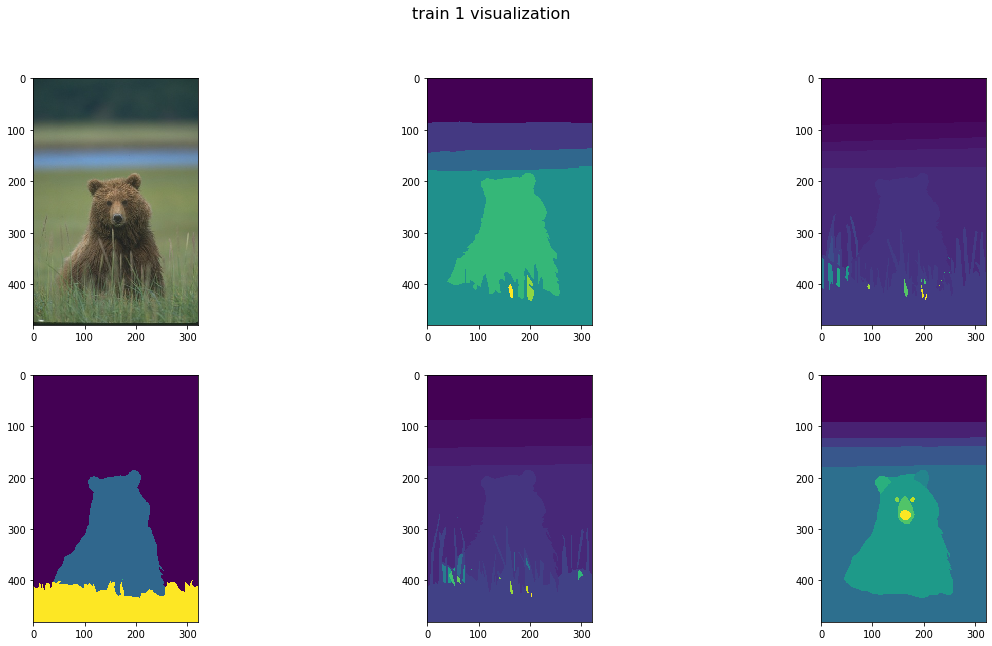

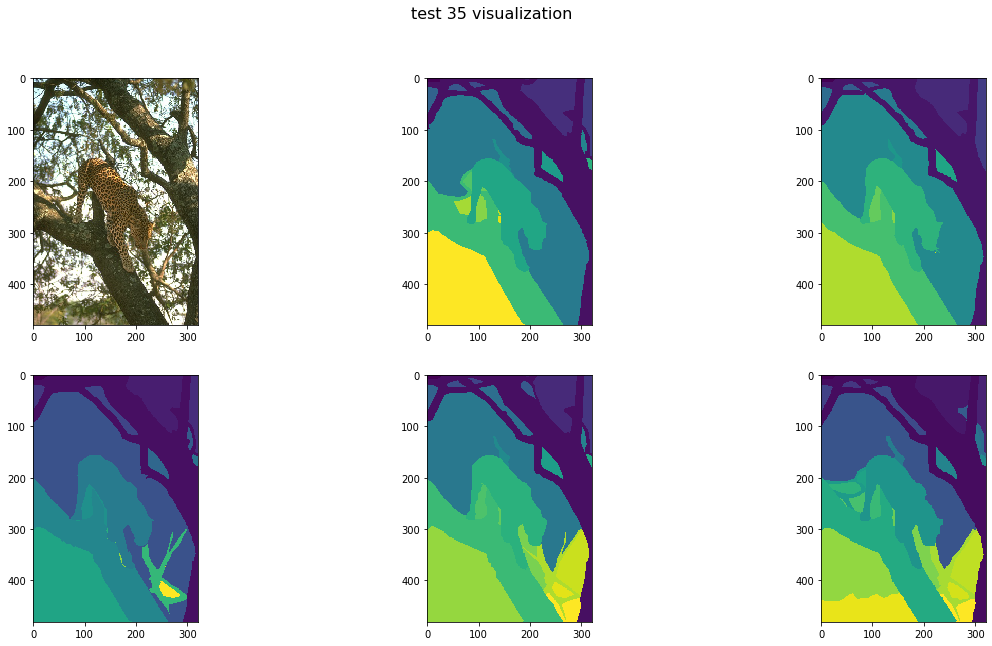

In [15]:
# A function that returns n random indices in the range between 0 and 50 (since the test dataset is only 50 images)
def get_random_images(n):
  rands = random.sample(range(0, 50), n)
  return rands

datasets = ["TRAIN", "TEST"]
randoms = get_random_images(2) # Calling the above function to get 2 random images to visualize

# Visualize a sample from training dataset and a sample from test data set alternatively
for i in range(len(randoms)):
  visualize_image(randoms[i], datasets[i & 1])

In [52]:
# # For the comparison part
# f = []
# for i in range(len(randoms)):
#   f.append(get_ground_truth_images(randoms[i], datasets[i & 1]))

# # Writing f[i] as is, displays the ith figure
# # but they are displayed automatically when each axis is given the image to show, 'ax.imshow(image)'
# # they are also saved in the Ground-Truth folder with the name 'GT_only_{dataset_name}_{index}'

* If working on Google Collab

## 3. Segmentation Using K-means

Every image pixel is a feature vector of 3-dimension {R, G, B}. We will 
use this feature representation to do the segmentation.

* ###  Our own implementation of K-means

In [ ]:
#K-means
def Kmeans(D,k,trials):

  #initialze k empty sets
  sets=[set() for i in range(k)]

  #initialize labels vector
  n = D.shape[0]
  labels= np.zeros(n)
  labels = labels.astype(np.int32)

  #randomly select k centroids
  random_indices = np.random.choice(n, size=k, replace=False)
  means = D[random_indices, :]

  itr=0
  temp = [set() for i in range(k)]

 #for t in range(trials): -> needs number of trials to be exact
  while(1): 
    itr=itr+1
    
    #Cluster Assignment
    for i in range(n): #for every data point
      min=math.inf
      for j in range(k): #for every centroid
        dist=(D[i]-means[j])**2
        dist = np.sum(dist)
        dist = np.sqrt(dist)
        if(dist<min):  #Assign to closest centroid
          min=dist
          min_j=j
      sets[min_j].add(i)
      labels[i]=min_j
      
    #Centroid Update
    for i in range(k):
      length=len(sets[i])
      sum=np.zeros((1,k))
      if(length>0): 
        for j in sets[i]:
          sum=sum + D[j]
        means[i]=sum/length

    #Check if there's no update in the cluster assignment
    if(itr>1):
      count=0
      for i in range(k):
        count = count + len(sets[i] - temp[i])
      if(count==0):
        break

    #store and clear sets for next iteration    
    for i in range(k):
      temp[i]=sets[i].copy()
      sets[i].clear()
    
    return labels, means

### a. Apply K-means to obtain 3,5,7,9,11 clusters

* ### K-means on every image separately of the test dataset separately - REQUIRED

In [16]:
def image_segmantaion(array, K, path):

    #Array to store images
    result=np.zeros([],int)

    #Array to store labels
    img = cv.imread(array[0])
    Z = img.reshape((-1,3))
    labels=np.zeros((len(array),Z.shape[0]))

    #Get Current Directory to save images
    path = os.path.join(path , str(K))
    if(not os.path.exists(path)):
        os.mkdir(path)

    #Segmanting all 200 train images
    for i in range(len(array)):
        
        img = cv.imread(array[i])
        Z = img.reshape((-1,3))
        
        # convert to np.float32
        Z = np.float32(Z)
        
        # define criteria, number of clusters(K) and apply kmeans()
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        ret, label, center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)

        #our own k-means
        #label, center = Kmeans(Z,K)
        
        #Store labels
        labels[i]=label.reshape(1,label.shape[0]) 

        # Now convert back into uint8, and make original image
        center = np.uint8(center)
        res = center[label.flatten()]
        seg_img = res.reshape((img.shape))

        #Save them to an array
        #result=np.append(result,res2)

        #Save segmented images 
        #if len(os.listdir('path')) != 0: (If segmentations changed for same K, then they have to be replaced)
        new_name=os.path.basename(array[i])
        new_name= 'seg_'+ new_name
        cv.imwrite(os.path.join(path ,new_name), seg_img)

    return labels


In [17]:
#Create a directory to save all segmented images inside
# Directory
directory = "Segmented-Images"
    
#Parent Directory path
# parent_dir = "./content/output" # if local host
parent_dir = '/content/output'
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Image Segmentation
K=[3,5,7,9,11]
cluster_ids_test=[np.array([]) for i in K] #Array of all labels
j=0
for i in K:
    cluster_ids_test[j] = image_segmantaion(test, i, path)
    j+=1

* ### Training Model (K-means on all training images combined), then Testing - NOT REQUIRED
 

In [ ]:
### Combine all images together
def combine_training_images(array):

    #Number of pixels/images
    img = cv.imread(array[0])
    x=img.shape[0]
    y=img.shape[1]
    number_of_pixels=x*y
    
    #Store all training images inside
    n=len(array)    #number of images
    data=np.zeros((n*number_of_pixels,3)) #3 features for every pixel

    #Combining all 200 train images together
    for i in range(n):
        
        img = cv.imread(array[i])
        Z = img.reshape((-1,3))
        
        # convert to np.float32
        Z = np.float32(Z)

        data[i*number_of_pixels:(i*number_of_pixels)+number_of_pixels]=Z
    
    return data

### Train the Image Segmentation model
def train_model(array, K):
    kmeans = KMeans(n_clusters=K, max_iter=600, algorithm = 'auto')
    results = kmeans.fit(array)
    return results

### Test the Image Segmentation model
def test_model(test, training_results, K, path):

    #Get Current Directory to save images
    path = os.path.join(path , str(K))
    if(not os.path.exists(path)):
        os.mkdir(path)

    #Centers of clusters
    centers=training_results.cluster_centers_
    print(f'{K} Centers:\n {centers}')
    centers = np.uint8(centers)

    n=len(test)   #number of test images

    #get number of pixels
    img = cv.imread(test[0])
    Z = img.reshape((-1,3))
    number_of_pixels = Z.shape[0]   #number of test images

    #Array of cluster ids of all pixels of all images
    cluster_ids=np.zeros((n,number_of_pixels)) 

    #For all test images 
    for i in range(n):
        img = cv.imread(test[i])
        Z = img.reshape((-1,3))
            

        #for every pixel, put it in most similar cluster
        for j in range(number_of_pixels):
            min=math.inf
            for k in range(K): #loop on all clusters
                dist = math.dist(Z[j],centers[k]) #euclidean distance 
                if(dist<min):
                    min=dist
                    cluster_ids[i][j]=k
        
        #Create segmented colored image 
        cluster_ids = np.uint8(cluster_ids)
        res = centers[cluster_ids[i]]
        seg_img = res.reshape((img.shape))

        #Save segmented images 
        new_name=os.path.basename(test[i])
        new_name= 'seg_'+ new_name
        cv.imwrite(os.path.join(path ,new_name), seg_img)

    return cluster_ids       


* Combine all test images into one array and train the model 5 times, once for each K

In [ ]:
#Combine training images
#train_combined = combine_training_images(train)

#Train the model
#K=[3,5,7,9,11]
#results = [np.array([]) for i in K] #array of training results (result for each value of k)
#j=0
#for k in K:
#    results[j] = train_model(train_combined,k)
#    j+=1

* Test the 5 training models, one for each K

In [ ]:
## Create a directory to save all segmented images inside
# Directory
#directory = "Train Model, then Testing"
    
# Parent Directory path
#parent_dir = "./content/output"
    
# Path
#path = os.path.join(parent_dir, directory) 
#if(not os.path.exists(path)):
#    os.mkdir(path)
    
# Directory
#directory = "Test-Segmented-Images"
    
# Parent Directory path
#parent_dir = "./content/output/Train Model, then Testing"
    
# Path
#path = os.path.join(parent_dir, directory) 
#if(not os.path.exists(path)):
#    os.mkdir(path)

## Image Segmentation (Test)
#K=[3,5,7,9,11]
#cluster_ids_test=[np.array([]) for i in K] #List of array of all cluster ids
#j=0
#for k in K:
#    cluster_ids_test[j] = test_model(test, results[j],k, path)
#    j+=1

3 Centers:
 [[177.19946694 199.2739537  196.86358181]
 [ 37.44237542  53.26421705  50.16950943]
 [ 99.74461431 120.79264365 119.36852397]]
5 Centers:
 [[154.78457316 144.52889337 119.1954775 ]
 [ 29.34404111  43.02171646  39.28553413]
 [ 73.61896165  96.24223299  94.62026417]
 [102.78943357 150.22781099 170.68445364]
 [198.52783209 217.49426105 212.65414051]]
7 Centers:
 [[ 85.81730436 122.89286311 132.96746186]
 [ 51.75882303  77.69015271  79.39246962]
 [210.78188329 226.81894019 218.98183005]
 [165.2656492  157.61613695 134.82644138]
 [ 23.99076964  35.28915443  30.3745226 ]
 [114.69438001 102.68165324  76.62190237]
 [119.91732626 174.10129551 199.15313718]]
9 Centers:
 [[192.84180087 193.03724334 171.80617691]
 [110.50940079  98.05798641  72.54331847]
 [ 18.45491063  27.53995153  23.12841187]
 [216.0064025  237.84599707 236.26871356]
 [120.25862311 177.41097248 204.30306561]
 [ 42.81922672  62.85959405  59.85914089]
 [157.17316709 145.97331671 120.96495006]
 [ 61.35761053  95.886141

### b. Evaluation using F-measure and Conditional Entropy

In [ ]:
def sizeOfIntersection(cluster,truth):
  size=0
  n=len(cluster)
  for i in range(n):
    if(cluster[i] in truth):
      size+=1
  return size

# Purity
def Purity(clusters, truths, numElements):
  #Total Purity
  purity=0 

  #Name each cluster
  k=len(clusters)
  results = np.zeros((k,2), dtype=object)

  for i in range(k):
    max= -1
    for j in range(len(truths)):
      temp=sizeOfIntersection(clusters[i], truths[j])
      if(temp>max):
        max=temp
        max_T=j
    results[i][0]=max_T #index of best matching class
    results[i][1]=max   #number elements matched from best matching class

  #Calculate Purity
  purity_i = np.zeros(k)
  for i in range(k):
    purity_i[i]=results[i][1]/len(clusters[i])
    purity+=purity_i[i]*len(clusters[i])/numElements
  return results,purity_i, purity

# 1. F-measure
def FMeasure(clusters, truths, numElements):
  #Call Purity Function
  results,prec, purity = Purity(clusters, truths, numElements)

  #Evaluate F-measure
  F=0
  k=len(clusters)

  #Calculate Recall
  rec=np.zeros(k)
  for i in range(k):
    j=results[i][0]
    rec[i]=results[i][1]/(len(truths[j]))

  #Calculate F  
  for i in range(k):
    temp=(2*prec[i]*rec[i])/(prec[i]+rec[i])
    F+=temp
  F/=k
  return F

# 2. Conditional Entropy
def conditional_entropy(clusters, truths, numElements):
  k=len(clusters)
  r=len(truths)
  #Conditional Entropy of T with respect to Ci
  H_i = np.zeros(k)
  for i in range(k):
    for j in range(r):
      nij=sizeOfIntersection(clusters[i], truths[j])
      ni=len(clusters[i])
      if(nij>0):
        H_i[i] -= (nij/ni)*math.log((nij/ni),2)
  i=0      
  for i in range(k):
    ni=len(clusters[i])
    H_i[i] = (ni/numElements) * H_i[i]
  H=np.sum(H_i)
  return H

In [ ]:
def evaluate(img_indx, K, cluster_ids):

    #Map K with its index
    k = int((K-3)/2)

    #Get the matching clusster ids
    cluster_ids = cluster_ids[k][img_indx]  #get cluster ids of segmented image (testing)
    gt_dataset = gt_test
    
    #Get corresponding ground truth image
    gt_img = scipy.io.loadmat(gt_dataset[img_indx])
    gt_img = np.squeeze(gt_img['groundTruth'])

    #Use first ground truth image to get image shape
    gt_img_for_shape = gt_img[0][0][0][0]
    x=gt_img_for_shape.shape[0] 
    y=gt_img_for_shape.shape[1]

    #Reshape labels vector of segmented image
    #print(f'Segmented Image (using our K-means based model (K={K}))')
    cluster_ids = cluster_ids.reshape((x,y))
    #plt.imshow(cluster_ids)
    #plt.show() 
    cluster_ids = cluster_ids.flatten()
    cluster_ids = np.uint8(cluster_ids)

    #Divide them into clusters (each cluster has the indices of corresponding pixels)
    clusters=[np.array([]) for i in range(K)]
    for i in range(len(cluster_ids)):
        clusters[cluster_ids[i]] = np.append(clusters[cluster_ids[i]], i)

    #number of ground truth segments
    M = gt_img.shape[0]

    #Loop on all ground truth images, report measures M times (Call F-measure and Conditional Entropy)
    F_sum = 0 
    C_sum = 0
    print(f'For image {img_indx+1}:')
    for i in range(M):

        #ground truth labels (number i/M)
        #print(f'Segmented Ground Truth number {i+1}: ')
        curr_gt_labels = gt_img[i][0][0][0]     
        #print(curr_gt_labels)
        #plt.imshow(curr_gt_labels)
        #plt.show()
        curr_gt_labels = curr_gt_labels.flatten()
        curr_gt_labels = np.uint8(curr_gt_labels)

        #Divide truth labels into sets (each set has the indices of corresponding pixels)
        truth_size = np.max(curr_gt_labels) + 1         #number of different ground truth labels
        truths=[np.array([]) for i in range(truth_size)]
        for j in range(len(curr_gt_labels)):
            truths[curr_gt_labels[j]] = np.append(truths[curr_gt_labels[j]], j)

        #Call the evaluating functions
        F = FMeasure(clusters, truths, x*y)
        F_sum+=F
        C = conditional_entropy(clusters, truths, x*y)
        C_sum+=C
        print(f'For Ground Truth = {i+1}: F-Measure = {F}, Conditional Entropy = {C}')

    #Get average of the M trials
    F=F_sum/M
    print(f'Average F-Measure = {F}')
    C=C_sum/M
    print(f'Average C-Measure = {C}\n')

    return F, C

In [ ]:
#Test evaluate for all 50 images for all Ks
K=[3,5,7,9,11]
results = [np.array([]) for i in K] #array of average of evaluation results
j=0
for k in K:
    print(f'\nFor K={k}:\n')
    F_sum=0
    C_sum=0
    for i in range(len(test)): 
        F,C = evaluate(i, k, cluster_ids_test) #i: image index, k: number of clusters
        F_sum+=F
        C_sum+=C
    F=F_sum/len(test)
    C=C_sum/len(test)
    print(f'Average F-Measure per dataset = {F}')
    print(f'Average Conditional Entropy per dataset = {C}')


For K=3:

For image 1:
For Ground Truth = 1: F-Measure = 0.48086637790826153, Conditional Entropy = 1.5023822558110935
For Ground Truth = 2: F-Measure = 0.47570532637203766, Conditional Entropy = 1.5814197467537756
For Ground Truth = 3: F-Measure = 0.5445837526918035, Conditional Entropy = 1.843434985506313
For Ground Truth = 4: F-Measure = 0.48035337138453876, Conditional Entropy = 1.765207869526384
For Ground Truth = 5: F-Measure = 0.548319055585817, Conditional Entropy = 1.889889807212476
Average F-Measure = 0.5059655767884916
Average C-Measure = 1.7164669329620086

For image 2:
For Ground Truth = 1: F-Measure = 0.44808066529909335, Conditional Entropy = 1.7317820837680813
For Ground Truth = 2: F-Measure = 0.454410051286908, Conditional Entropy = 3.0243294302521093
For Ground Truth = 3: F-Measure = 0.4472251662903371, Conditional Entropy = 1.5724236561571536
For Ground Truth = 4: F-Measure = 0.4464174769936731, Conditional Entropy = 1.5729431499214506
For Ground Truth = 5: F-Measur

KeyboardInterrupt: 

Segmented Image (using our K-means based model (K=5))


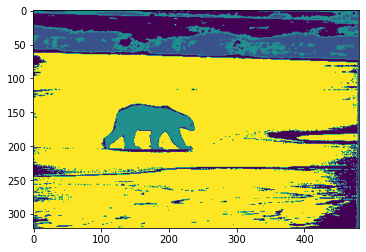

Segmented Ground Truth number 1: 


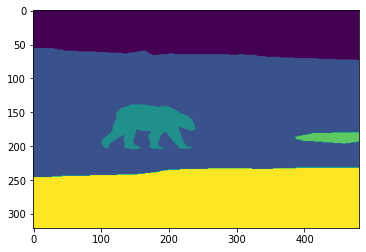

F-Measure = 0.41375476961722846
Conditional Entropy = 1.0723960420846967
Segmented Ground Truth number 2: 


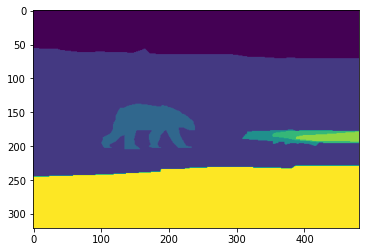

F-Measure = 0.4141945465373359
Conditional Entropy = 1.1417483247737072
Segmented Ground Truth number 3: 


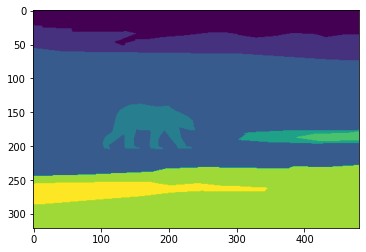

F-Measure = 0.5183639168082571
Conditional Entropy = 1.398867044875541
Segmented Ground Truth number 4: 


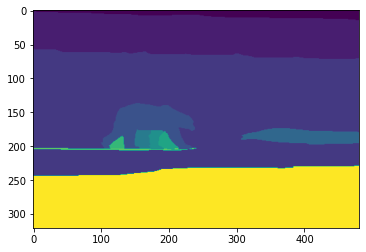

F-Measure = 0.4029535642790556
Conditional Entropy = 1.3377063337369175
Segmented Ground Truth number 5: 


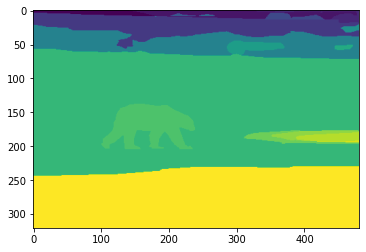

F-Measure = 0.5235122169579489
Conditional Entropy = 1.3967474304206746
Average F-Measure = 0.4545558028399652


In [ ]:
#Test evaluate for one image with pictures
img_indx=0
K=5
evaluate(img_indx, K)

## 4. Big Picture

a. Select a set of five images and display their corresponding ground truth 
against your segmentation results using K-means at K=5

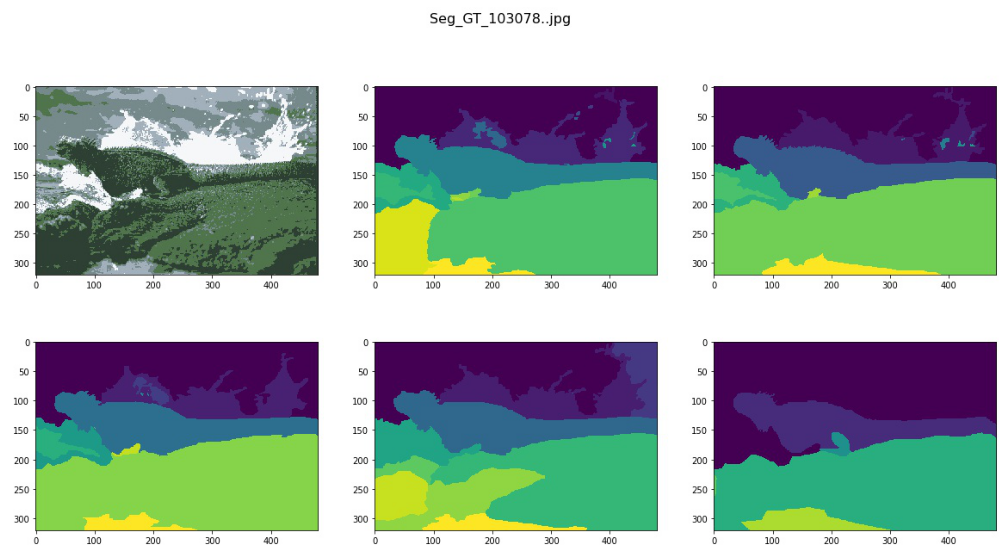

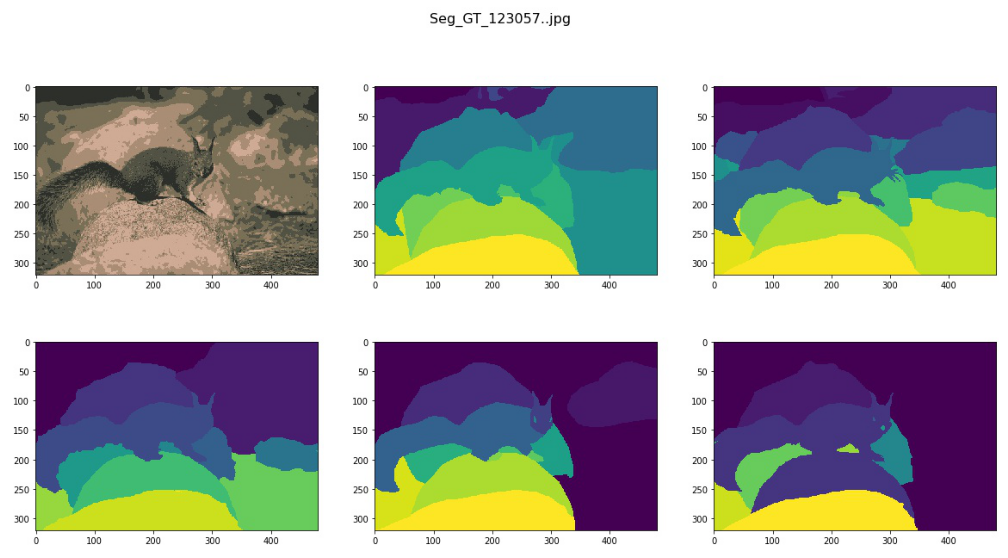

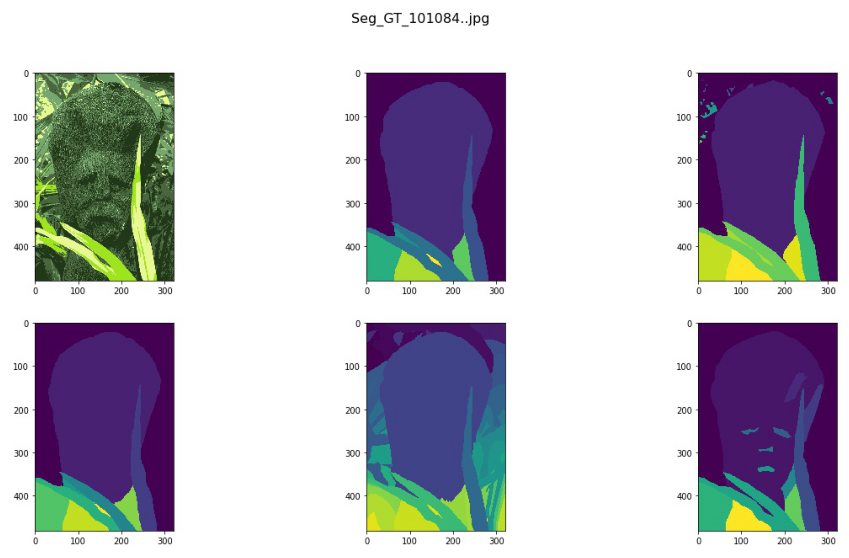

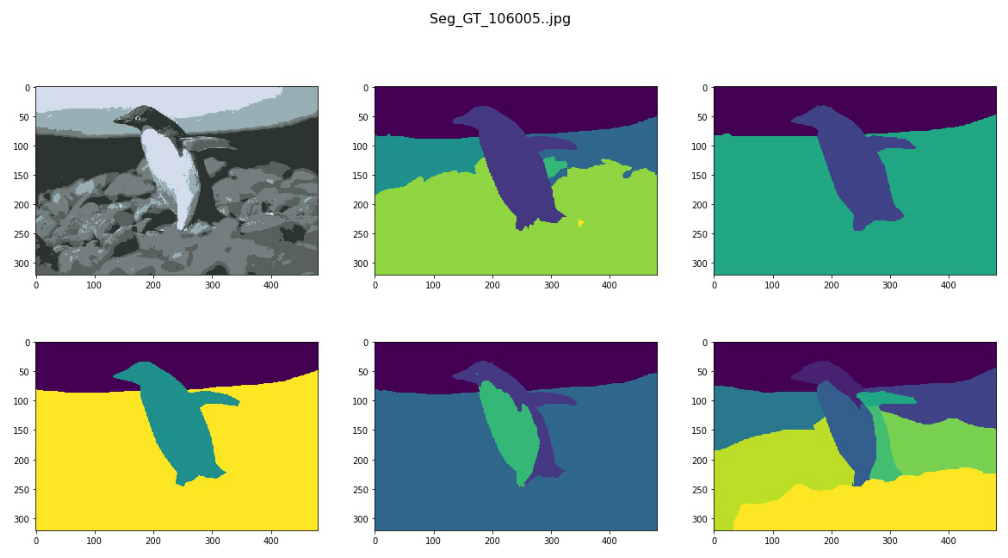

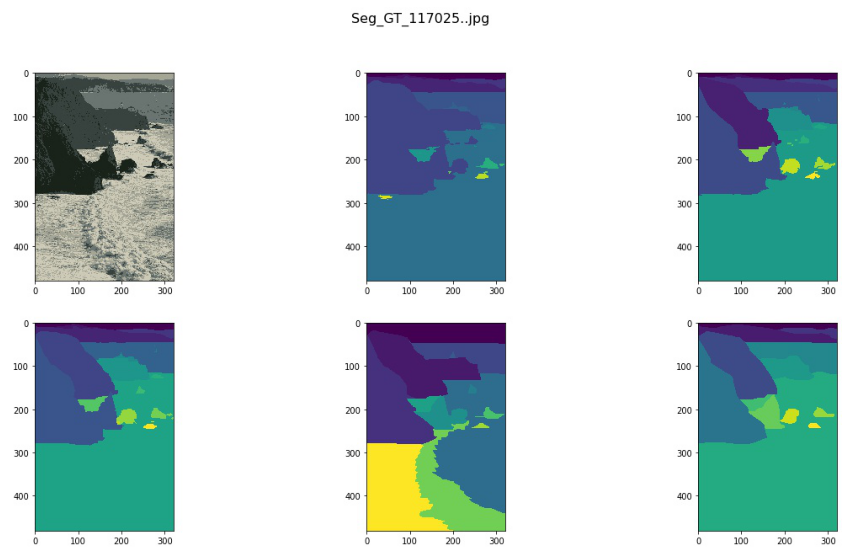

In [25]:
kmeans_seg = sorted(glob.glob("output/Segmented-Images/5/**/*.jpg", recursive=True))
samples = random.sample(range(50), 5)

for i in range(len(test)):
  visualize_segmented_image(i, kmeans_seg, 0, 0)
seg_vs_gt = sorted(glob.glob("output/Test-Segmented-Images/Segmented_vs_GT/**/*.jpg", recursive=True))

for sample in samples:
  curr_image = image.imread(seg_vs_gt[sample])
  plt.figure(figsize=(20,10))
  plt.axis('off')
  plt.imshow(curr_image)
  plt.show()
  plt.close()

In [51]:
print(samples)

[16, 40, 35, 5, 14]


b. Select the same five images and display their corresponding ground 
truth against your segmentation results using Normalized-cut for the 5-
NN graph, at K=5. 

## 5. Extra

In the previous parts, we used the color features RGB. We did not
encode the layout of the pixels. We want to modify that for K-means 
clustering to encode the spatial layout of the pixels.



i. Suggest a way to modify the feature vector to include spatial 
layout

### K-means on every image of test dataset separately - REQUIRED

In [26]:
def image_segmantaion_modified(array, K, path):

    #Array to store images
    result=np.zeros([],int)

    #Array to store labels
    img = cv.imread(array[0])
    Z = img.reshape((-1,3))
    labels=np.zeros((len(array),Z.shape[0]))

    #Get Current Directory to save images
    path = os.path.join(path , str(K))
    if(not os.path.exists(path)):
        os.mkdir(path)

    #Segmanting all 200 train images
    for i in range(len(array)):
        
        #read image and save its shape
        img = cv.imread(array[i])
        shape = img.shape

        #store number of rows and columns
        x = img.shape[0] #number of rows
        y = img.shape[1] #number of columns
        N = x*y          #total number of pixels

        #features vector
        features = img.reshape((-1,3))
        features = np.c_[ features, np.zeros(N), np.zeros(N)]  # add 2 extra columns

        # include spatial layout to feature vector
        k=0
        for r in range(x):     #rows
            for c in range(y): #columns
                features[k][3]=r
                features[k][4]=c
                k+=1
        
        # convert to np.float32
        features = np.float32(features)
        
        # define criteria, number of clusters(K) and apply kmeans()
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        ret, label, center=cv.kmeans(features, K, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
        
        #Store labels
        labels[i]=label.reshape(1,label.shape[0])

        # Now convert back into uint8, and create segmented image
        center = np.uint8(center)
        center_RGB = center[:,0:3]
        res = center_RGB[label.flatten()]
        seg_img = res.reshape((shape))

        #Save them to an array
        #result=np.append(result,res2)

        #Save segmented images 
        #if len(os.listdir('path')) != 0: (If segmentations changed for same K, then they have to be replaced)
        new_name=os.path.basename(array[i])
        new_name= 'modified_seg_'+ new_name 
        cv.imwrite(os.path.join(path ,new_name), seg_img)

    return labels


In [27]:
## Create a directory to save all modified segmented images inside
# Directory
directory = "Modified-Segmented-Images"
    
# Parent Directory path
# parent_dir = "./content/output" # if local host
parent_dir = "/content/output" # if colab
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Image Segmentation
K=[3,5,7,9,11]
mod_cluster_ids_test=[np.array([]) for i in K] #Array of all labels
j=0
for i in K:
    mod_cluster_ids_test[j] = image_segmantaion_modified(test, i, path)
    j+=1

ii. Contrast the results you obtained in 4.a to the results you 
obtained by considering the spatial layout.

In [46]:
def display_2_images(images, index):
  rows = 2
  cols = 1
  fig = plt.figure(figsize=(20,10))
  my_file = 'Modified_vs_normally_segmented_image_' + str(index)
  my_path = '/content/output/Test-Segmented-Images/Modifed_vs_Normally_Segmented_Images' #(if on Google Collab)
  # my_path = './content/output/Test-Segmented-Images/Modifed_vs_Normally_Segmented_Images'
  for i in range(len(images)):
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
  fig.suptitle(my_file, fontsize=16)
  plt.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')
  plt.show()
  plt.close()

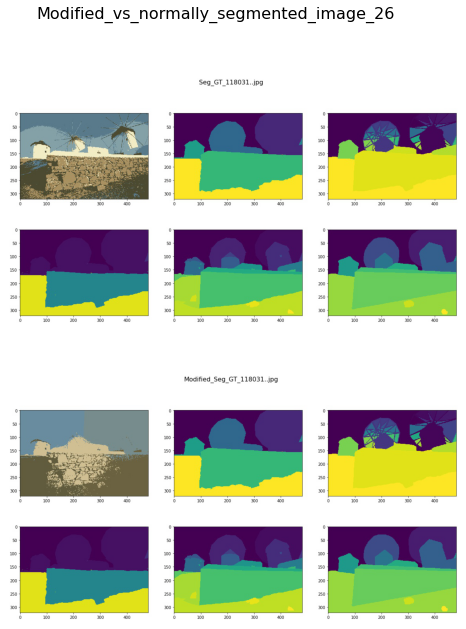

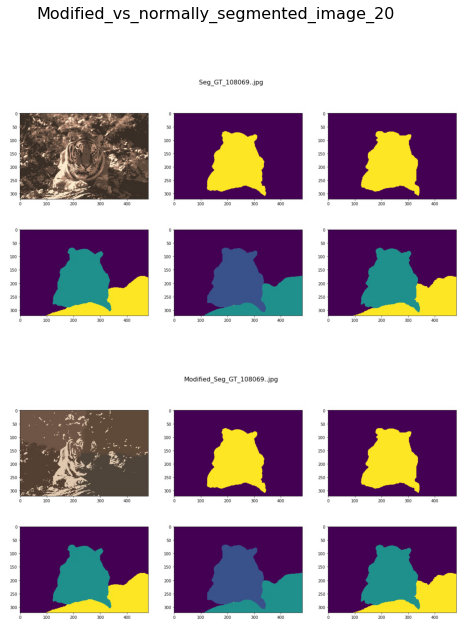

In [47]:
kmeans_seg_modified = sorted(glob.glob("output/Modified-Segmented-Images/5/**/*.jpg", recursive=True))
modified_samples = random.sample(range(50), 2)

# for i in range(len(test)):
  # visualize_segmented_image(i, kmeans_seg_modified, 0, 1)
modified_seg_vs_gt = sorted(glob.glob("output/Test-Segmented-Images/Modified_Segmented_vs_GT/**/*.jpg", recursive=True))

for sample in modified_samples:
  imgs = []
  curr_image = image.imread(seg_vs_gt[sample])
  curr_modified_image = image.imread(modified_seg_vs_gt[sample])
  imgs.append(curr_image)
  imgs.append(curr_modified_image)
  display_2_images(imgs, sample)

In [50]:
# Zipping and downloading output folder as output.zip
!zip -qq -r /content/output.zip /content/output
files.download("/content/output.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 ### Training Model (K-means on all training images combined), then testing - NOT REQUIRED

In [ ]:
### Combine all images together
def combine_training_images_modified(array):

    #Number of pixels/images
    img = cv.imread(array[0])
    x=img.shape[0]
    y=img.shape[1]
    number_of_pixels=x*y
    
    #Store all training images inside
    n=len(array)    #number of images
    data=np.zeros((n*number_of_pixels,5)) #5 features for every pixel (R,G,B, x and y)

    #Combining all 200 train images together and add 2 new features
    for i in range(n):
        
        img = cv.imread(array[i])
        features = img.reshape((-1,3)) # 3 main columns
        features = np.c_[ features, np.zeros(number_of_pixels), np.zeros(number_of_pixels)]  # add 2 extra columns

        # Include spatial layout to feature vector
        k=0
        for r in range(x):     #rows
            for c in range(y): #columns
                features[k][3]=r
                features[k][4]=c
                k+=1

        # Convert to np.float32
        features = np.float32(features)
        
        # Add features of image i to array of all features
        data[i*number_of_pixels:(i*number_of_pixels)+number_of_pixels]=features
    
    return data


### Test the Image Segmentation model
def test_model_modified(test, training_results, K, path):

    #Get Current Directory to save images
    path = os.path.join(path , str(K))
    if(not os.path.exists(path)):
        os.mkdir(path)

    #Centers of clusters
    centers=training_results.cluster_centers_
    print(f'{K} Centers:\n {centers}')
    centers = np.uint8(centers)

    n=len(test)   #number of test images

    #get number of pixels, number of rows and number of columns
    img = cv.imread(test[0])
    x = img.shape[0] #number of rows
    y = img.shape[1] #number of columns
    number_of_pixels = x*y   #total number of pixels

    #Array of cluster ids of all pixels of all images
    cluster_ids=np.zeros((n,number_of_pixels)) 

    #For all test images 
    for i in range(n):
        img = cv.imread(test[i])
        features = img.reshape((-1,3))

        #For Spatial Modification
        features = np.c_[ features, np.zeros(number_of_pixels), np.zeros(number_of_pixels)]  # add 2 extra columns

        # Include spatial layout to feature vector
        k=0
        for r in range(x):     #rows
            for c in range(y): #columns
                features[k][3]=r
                features[k][4]=c
                k+=1

        #for every pixel, put it in most similar cluster
        for j in range(number_of_pixels):
            min=math.inf
            for k in range(K): #loop on all clusters
                dist = math.dist(features[j],centers[k]) #euclidean distance 
                if(dist<min):
                    min=dist
                    cluster_ids[i][j]=k
        
        #Create segmented colored image 
        cluster_ids = np.uint8(cluster_ids)
        centers_RGB=centers[:,0:3]
        res = centers_RGB[cluster_ids[i]]
        seg_img = res.reshape((img.shape))

        #Save segmented images 
        new_name=os.path.basename(test[i])
        new_name= 'seg_'+ new_name
        cv.imwrite(os.path.join(path ,new_name), seg_img)

    return cluster_ids 

In [ ]:
#Combine training images
#train_combined_mod = combine_training_images_modified(train)

#Train the model with new features
#K=[3,5,7,9,11]
#results_mod = [np.array([]) for i in K] #array of training results (result for each value of k)
#j=0
#for k in K:
#    print(k)
#    results_mod[j] = train_model(train_combined_mod,k)
#    j+=1

3
5
7
9
11


In [ ]:
## Create a directory to save all segmented images inside
# Directory
#directory = "Modified-Test-Segmented-Images"
    
# Parent Directory path
#parent_dir = "./content/output/Train Model, then Testing"
    
# Path
#path = os.path.join(parent_dir, directory) 
#if(not os.path.exists(path)):
#    os.mkdir(path)

## Image Segmentation (Test)
#K=[3,5,7,9,11]
#cluster_ids_test=[np.array([]) for i in K] #List of array of all cluster ids
#j=0
#for k in K:
#    cluster_ids_test[j] = test_model_modified(test, results_mod[j],k, path)
#    j+=1

3 Centers:
 [[162.97715375 182.30880526 179.36891565 116.95077396 288.43150047]
 [ 80.87263794 100.43609652  98.10418427 166.62286132 106.02583742]
 [ 63.8958077   83.06303353  81.38310503 179.93756877 366.70266072]]
154401
5 Centers:
 [[ 68.95134084  90.35786737  90.1198887  245.52077087 364.58916369]
 [174.91906019 195.91335887 194.17616069 133.24102947 296.49747262]
 [ 70.31917159  86.40328875  82.38103132  80.31725723 364.15446381]
 [ 73.23050563  95.06014725  94.89147237 240.33455787 117.17727247]
 [ 98.04402548 114.38895021 109.13016112  79.4066603  103.81625279]]
154401
7 Centers:
 [[ 66.64011257  87.1751956   85.37569993 243.04869212  74.98399954]
 [ 68.79245613  90.12143844  89.00842756 242.66368944 405.96579922]
 [168.52832312 188.00004012 184.77849244 120.96035846 354.14229092]
 [ 70.34814233  92.20105331  94.2212197  232.94987445 241.69246061]
 [ 64.28456365  80.34780051  75.95321755  74.49131222 366.87822081]
 [ 64.26699441  80.64331075  75.47686729  73.4659824  113.902605